In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import ast

In [4]:
import CleanTweets as ct

[nltk_data] Downloading package stopwords to /Users/Lono/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Lono/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from nltk import bigrams
import itertools
import collections

In [6]:
african_names = pd.read_csv("africa_names.csv", names = ["names", "nan"])
fix_list = african_names["names"].to_list()

In [8]:
def get_wordcloud(df, text_col, title):# Generate a word cloud image
    wordcloud = WordCloud(background_color="white", width=1500, height=800).generate(' '.join(df[text_col]))

    # Display the generated image:

    plt.figure(figsize=(18,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.savefig('artefacts/' + title +'.eps', format='eps')

In [9]:
def draw_network(df, text_col, max_similarity, name):
    
    cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english') # You can define your own parameters
    X = cv.fit_transform(df[text_col])
    Xc = (X.T * X) # Cosine similarity of words

    names = cv.get_feature_names() # This are the entity names (i.e. keywords)
    df_co = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)

    a = df_co.stack().reset_index()
    a.columns = ['source', 'target','value']
    a_filtered=a.loc[ (a['value'] > max_similarity) & (a['source'] != a['target']) ]


    # Build your graph
    plt.figure(figsize=(20,10))
    G=nx.from_pandas_edgelist(a_filtered, 'source', 'target')

    # Plot the network:
    # pos = graphviz_layout(G)
    nx.draw(G, with_labels=True, node_color='orange', node_size=50, edge_color='green', linewidths=2, font_size=15)
    #plt.savefig('artefacts/' + name +'.eps', format='eps')

In [10]:
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/
def draw_cooccur_network(df, top_n_bigrams, col, title):
    terms_bigram = [list(bigrams(doc.split())) for doc in df[col]]
    bigramsls = list(itertools.chain(*terms_bigram))
    bigram_counts = collections.Counter(bigramsls)
    bigram_df = pd.DataFrame(bigram_counts.most_common(top_n_bigrams),
                                 columns=['bigram', 'count'])
    d = bigram_df.set_index('bigram').T.to_dict('records')

    # Create network plot 
    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    fig, ax = plt.subplots(figsize=(15, 8))
    pos = nx.spring_layout(G, k=2)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=12,
                     width=3,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.045, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.2),
                horizontalalignment='center', fontsize=13)
    plt.title(title)
    #plt.savefig('artefacts/' + title +'.eps', format='eps')
    plt.show()

# Publications

## 1. Time/volume - line chart

In [11]:
df = pd.read_csv('data/egypt_publications.csv', index_col=0)

In [12]:
df['pub_year'] = df['bib'].apply(lambda x: ast.literal_eval(x)['pub_year'])
df_not_nan = df[df['pub_year']!= 'NA']

Note we lose a couple of publications because a number of them do not have publication year attached

In [13]:
#df_not_nan['pub_year'] = pd.to_datetime(df_not_nan['pub_year'])
df_not_nan['pub_year'] = df_not_nan['pub_year'].astype(int)
df_groupedby_date = df_not_nan.groupby('pub_year').count()
df_groupedby_date.reset_index(inplace=True)

/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
df_groupedby_date['count'] = df_groupedby_date['container_type']

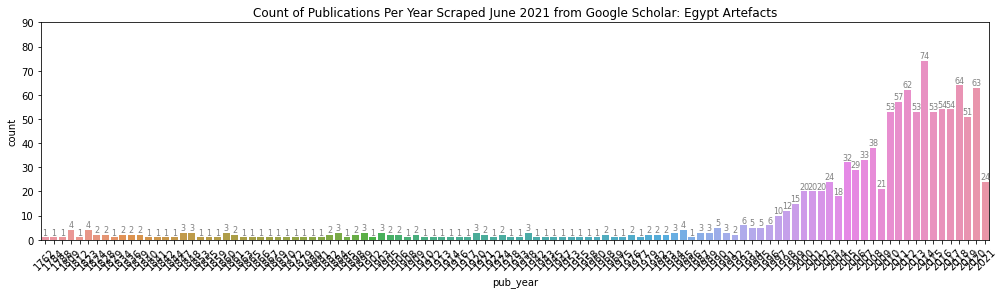

In [15]:
plt.figure(figsize=[17,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Scraped June 2021 from Google Scholar: Egypt Artefacts')
g = sns.barplot(data=df_groupedby_date, 
             x="pub_year", 
             y="count") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,90) #To make space for the annotations
#plt.savefig('artefacts/ea_gs_pubcount.eps', format='eps')

In [16]:
df_groupedby_date_2016 = df_groupedby_date[df_groupedby_date['pub_year'] > 2015]

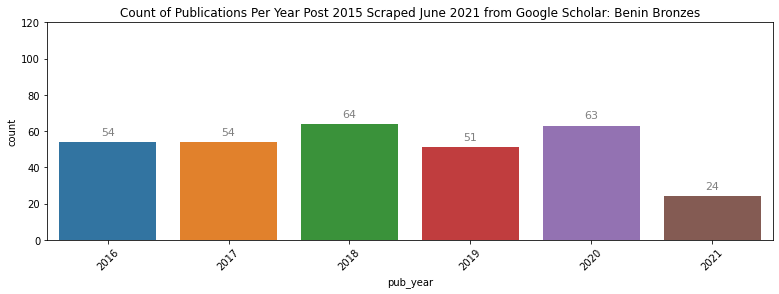

In [17]:
plt.figure(figsize=[13,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Post 2015 Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=df_groupedby_date_2016, 
             x="pub_year", 
             y="count")
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
_ = ax.set_ylim(0,120) #To make space for the annotations
#plt.savefig('artefacts/ea_gs_pubcountpost2015.eps', format='eps')

## 2. Keywords - Network diagram

In [18]:
def get_abstract(x):
    try:
        return ast.literal_eval(x)['abstract']
    except KeyError:
        return ''

In [19]:
df['abstract'] = df['bib'].apply(lambda x: get_abstract(x) )
df_abs = df[df['abstract']!= '']

We lose around 100 publications because they do not have abstracts

In [20]:
df_abs = ct.clean_tweets(df_abs,'abstract','lemma_text',
                general_clean=True,lemma=True,stem=False,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 9.933815240859985s. Use the [lemma_text] column to perform your analysis/modeling on


In [21]:
df_abs = ct.clean_tweets(df_abs,'abstract','stem_text',
                general_clean=True,lemma=False,stem=True,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 1.9024879932403564s. Use the [stem_text] column to perform your analysis/modeling on


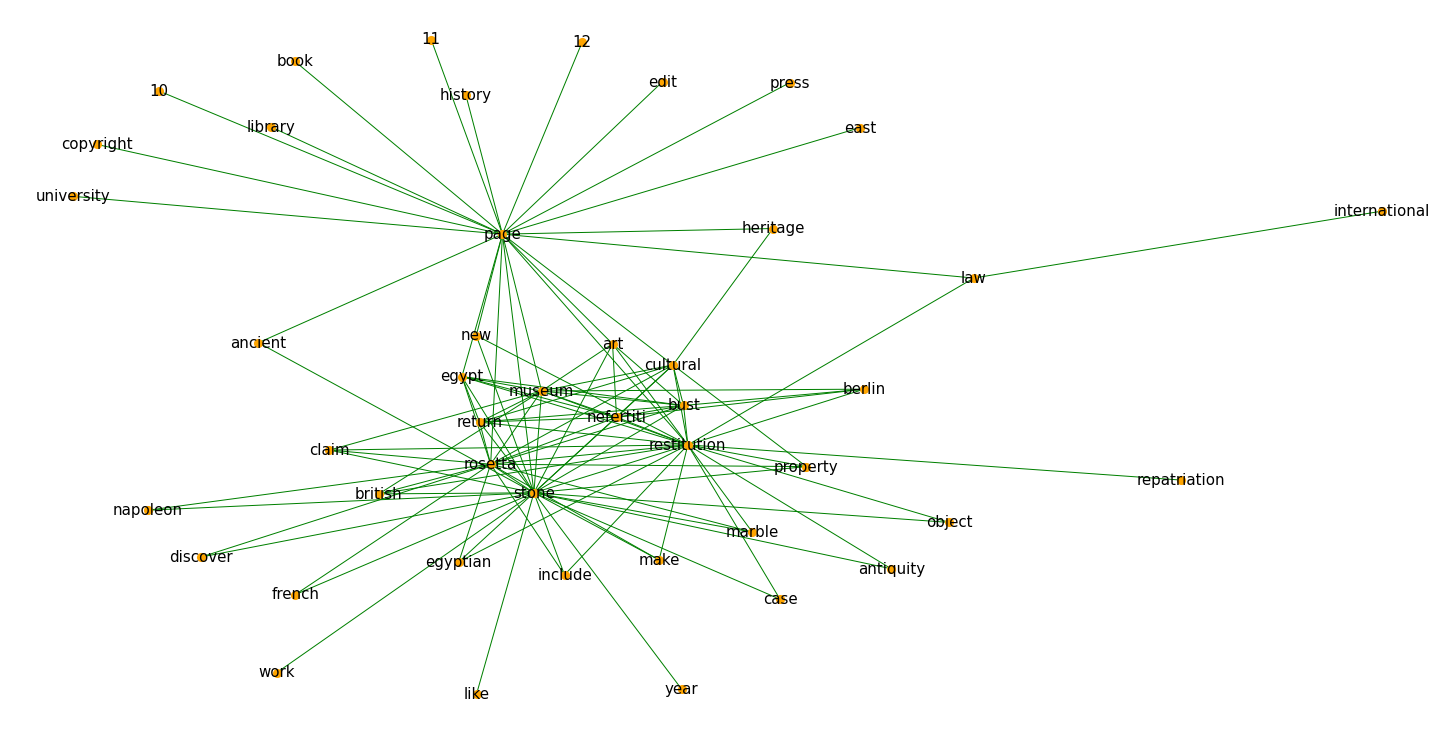

In [22]:
draw_network(df_abs, 'lemma_text', 36, 'ea_abstracts_36') 

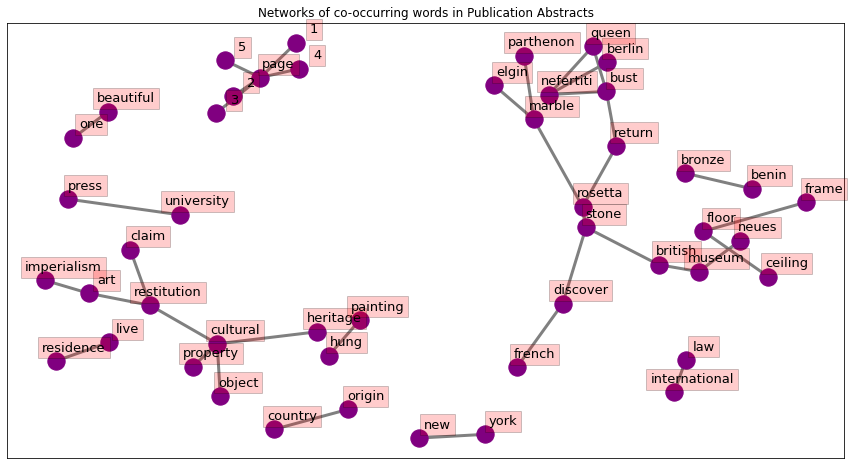

In [23]:
draw_cooccur_network(df_abs, 43,'lemma_text', 'Networks of co-occurring words in Publication Abstracts')

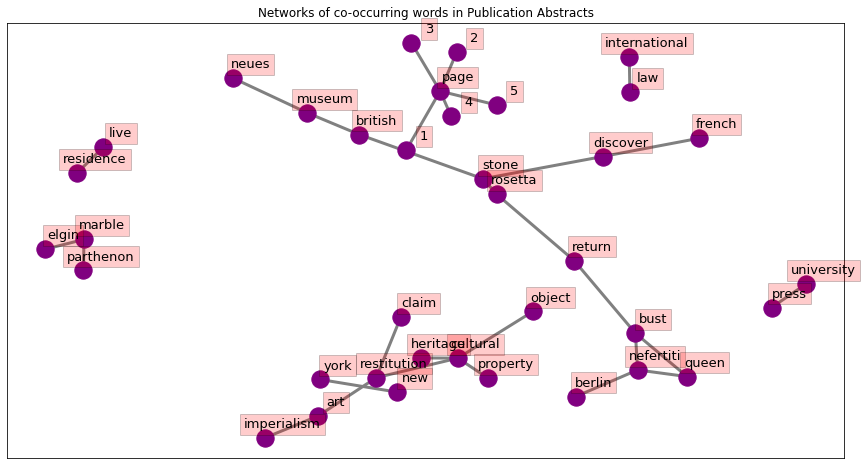

In [24]:
draw_cooccur_network(df_abs, 35,'lemma_text', 'Networks of co-occurring words in Publication Abstracts')

## 3. Peoples vs citations vs ethnicity - CSV list, network diagram

In [25]:
from ethnicolr import pred_wiki_ln, pred_wiki_name

Using TensorFlow backend.


In [26]:
import unicodedata

In [27]:
def clean_name(name, surname=False):
    if surname == True:
        res = name.split(' ')[1:]
        surname = ' '.join(chars for chars in res)
        if surname == '':
            surname = name.split(' ')[0]
        name = surname
            
    name = name.lower()
    #remove phonetics
    name = ''.join((c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn'))
    return name

### Authors African vs Not

In [79]:
df = pd.read_csv('data/egypt_publications.csv', index_col=0)

In [80]:
df.shape

(1275, 13)

In [81]:
df['author'] = df['bib'].apply(lambda x: ast.literal_eval(x)['author'])

In [82]:
df['count'] = 1
dummy = df[['author', 'count']]
dummy1 = dummy.set_index('count').author.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'author'})

In [83]:
dummy1['author'] = dummy1['author'].apply(lambda x: clean_name(x) )

In [84]:
res = dummy1.groupby('author').agg('sum').reset_index().sort_values('count',ascending=False)
res['surname'] = res['author'].apply(lambda x: clean_name(x, True))

In [85]:
preds = pred_wiki_ln(res, "surname")
preds['african'] = preds['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

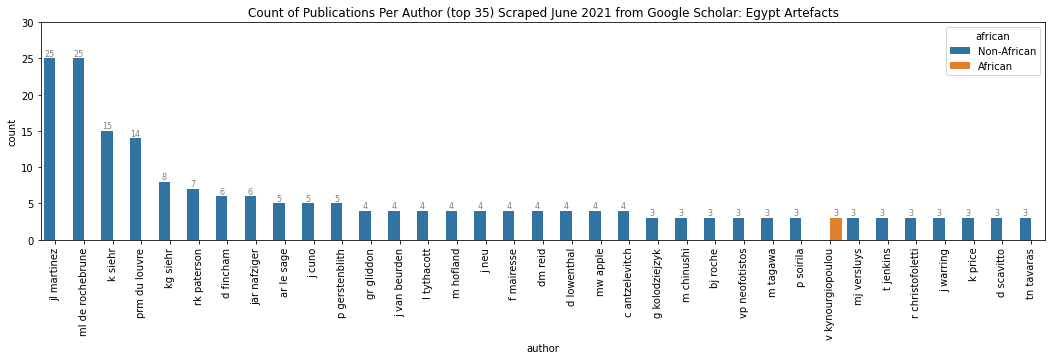

In [87]:
#manual fixes
#fix_list = ['ojaide', 'thebele', 'shyllon', 'sarr']
for name in fix_list:
    preds.loc[preds['surname']==name, 'african'] = 'African'
    
plt.figure(figsize=[18,4])
plt.xticks(rotation=90)
plt.title('Count of Publications Per Author (top 35) Scraped June 2021 from Google Scholar: Egypt Artefacts')
g = sns.barplot(data=preds[0:35], 
             x="author", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,30) #To make space for the annotations
#plt.savefig('ea_gs_pubsperauthor.eps', format='eps')

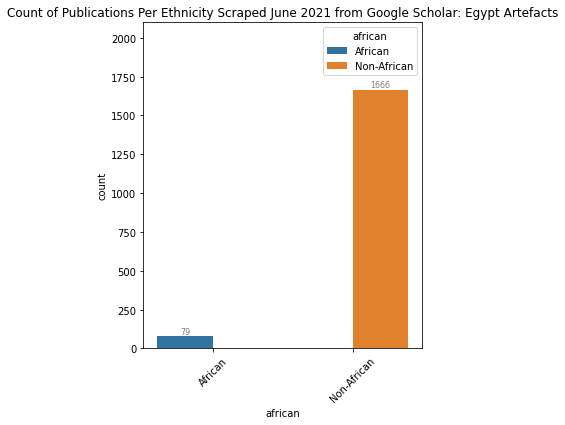

In [88]:
ratio = preds.groupby('african').agg('sum').reset_index()
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Ethnicity Scraped June 2021 from Google Scholar: Egypt Artefacts')
g = sns.barplot(data=ratio, 
             x="african", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,2100) #To make space for the annotations
#plt.savefig('ea_gs_pubsperethnicity.eps', format='eps')

### Authors vs citations

These are the publications that have citations and only from 2016. A whole lot less publications from the total collected

In [89]:
df = pd.read_csv('data/egypt_pub_citations.csv', index_col=0)
df['author'] = df['bib'].apply(lambda x: ast.literal_eval(x)['author'])
df['citing_authors'] = df['citations'].apply(lambda x: [item['author'] for item in ast.literal_eval(x)])
dummy = df[['author', 'num_citations']]

In [90]:
dummy1 = dummy.set_index('num_citations').author.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'author'})
dummy1['author'] = dummy1['author'].apply(lambda x: clean_name(x) )

In [91]:
res = dummy1.groupby('author').agg('sum').reset_index().sort_values('num_citations',ascending=False)
res['surname'] = res['author'].apply(lambda x: clean_name(x, True))

In [92]:
#ethnicity thing needs a specific dev environment
#https://ethnicolr.readthedocs.io/ethnicolr.html
preds = pred_wiki_ln(res, "surname")
preds['african'] = preds['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

In [ ]:
#manual fixes
for name in fix_list:
    preds.loc[preds['surname']==name, 'african'] = 'African'

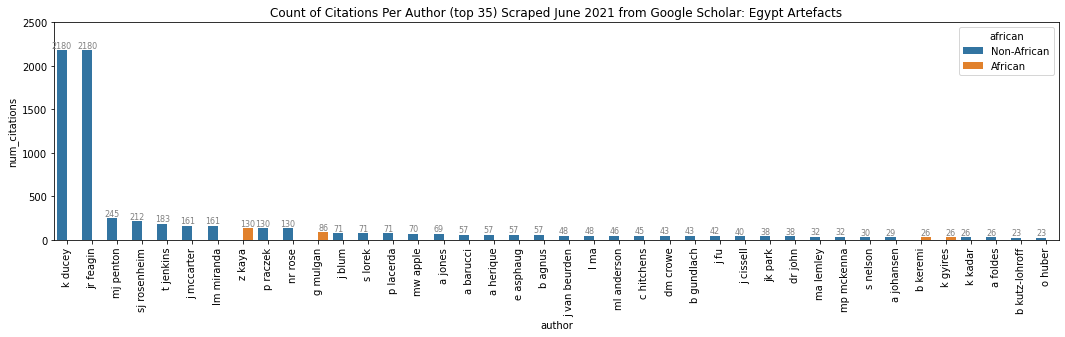

In [94]:
plt.figure(figsize=[18,4])
plt.xticks(rotation=90)
plt.title('Count of Citations Per Author (top 35) Scraped June 2021 from Google Scholar: Egypt Artefacts')
g = sns.barplot(data=preds[0:40], 
             x="author", 
             y="num_citations",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,2500) #To make space for the annotations
#plt.savefig('ea_gs_citesperauthor.eps', format='eps')

In [95]:
ratio = preds.groupby('african').agg('sum').reset_index()

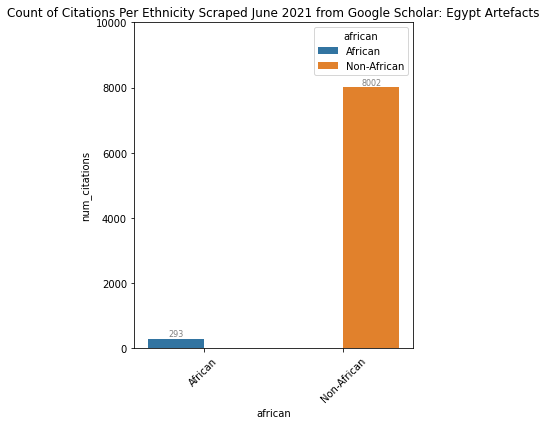

In [96]:
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of Citations Per Ethnicity Scraped June 2021 from Google Scholar: Egypt Artefacts')
g = sns.barplot(data=ratio, 
             x="african", 
             y="num_citations",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,10000) #To make space for the annotations
#plt.savefig('ea_gs_citesperethnicity.eps', format='eps')

# Media 

In [2]:
import regex

In [24]:
df = pd.read_csv('data/eg_google_content468_cleaned.csv', index_col=0)

### 1. Keywords - Network diagram: Pelonomi

The green newtork diagrams are with regards to word similarity based on the texts

In [28]:
print(df.shape)
df_text = df[~df['text'].isna()]
df_text['text_len'] = df_text['text'].apply(lambda x: len(x))
df_text.shape

(471, 6)


/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(439, 7)

In [29]:
df_text

,title,link,text,html_date,lemma_text,stem_text,text_len
0,Should the British Return the Stolen Rosetta S...,https://www.papermag.com/going-going-gone-2632...,If 2018 was a year plagued by inconvenient tru...,2019-03-18,2018 year plague inconvenient truth reimaginin...,2018 year plagu inconveni truth reimagin art w...,22891
1,The British Museum's claims to the Rosetta Sto...,http://www.elginism.com/similar-cases/the-brit...,"October 12, 2008\nThe British Museum’s claims ...",2008-10-12,october 12 2008 british museum claim rosetta s...,octob 12 2008 british museum claim rosetta sto...,12441
2,Egyptian museum calls for Rosetta Stone to be ...,https://www.telegraph.co.uk/news/2018/11/06/eg...,Egyptian museum calls for Rosetta Stone to be ...,2018-11-06,egyptian museum call rosetta stone return 200 ...,egyptian museum call rosetta stone return 200 ...,1973
3,The battle for the Rosetta Stone | The Indepen...,https://www.independent.co.uk/news/uk/this-bri...,The battle for the Rosetta Stone\nThings are l...,2013-10-26,battle rosetta stone thing look decidedly rock...,battl rosetta stone thing look decidedli rocki...,13388
4,Repatriation; restitution | The Rosetta Stone:...,https://jdownsrosetta.wordpress.com/category/r...,Egypt’s Antiquities Caught in the Revolution\n...,2011-04-06,egypt antiquity caught revolution alexander h ...,egypt antiqu caught revolut alexand h joff mid...,40981
6,Restitution and recent upheavals in Egypt | Pa...,https://www.pambazuka.org/governance/restituti...,"The ‘disorder, revolt or revolution in Egypt’ ...",2011-03-30,disorder revolt revolution egypt doesnt change...,disord revolt revolut egypt doesnt chang natur...,15218
7,Egypt renounces claim to the Rosetta stone and...,https://www.theartnewspaper.com/archive/egypt-...,"Egypt’s new director of antiquities, Ali Hassa...",1997-03-01,egypt new director antiquity ali hassan say ja...,egypt new director antiqu ali hassan said janu...,1164
8,Egypt calls on UK to return Rosetta Stone - Eg...,https://www.egyptindependent.com/egypt-calls-o...,"Yesterday, Egypt renewed its request for the B...",2018-11-07,yesterday egypt renew request british museum r...,yesterday egypt renew request british museum r...,2527
9,Renouncing the Universal Museum's Imperial Pas...,https://repository.usfca.edu/cgi/viewcontent.c...,2019-01-28T14:05:33-08:00 \n 2019-01-28T14:05:...,2012-04-05,2019 01 28t140533 0800 2019 01 28t140533 0800 ...,2019 01 28t140533 0800 2019 01 28t140533 0800 ...,596
10,"20 Works That Faced Claims of Looting, Plunder...",https://www.artnews.com/list/art-news/artists/...,Art theft typically conjures pieces ripped fro...,2021-02-26,art theft typically conjures piece ripped wall...,art theft typic conjur piec rip wall world cla...,1628


So, we lost a couple of articles because we could not get text from them (their text is NaN)

We also lose a couple that arent proper articles, maybe PDFs or something

In [13]:
df_text = df_text[~df_text['text'].astype(str).str.contains("�")]
df_text.shape

(365, 6)

In [14]:
text_col = 'lemma_text'

In [35]:
per = int(len(df_text)*0.4)

In [37]:
df_not_nan = df_text[~df_text['lemma_text'].isna()]

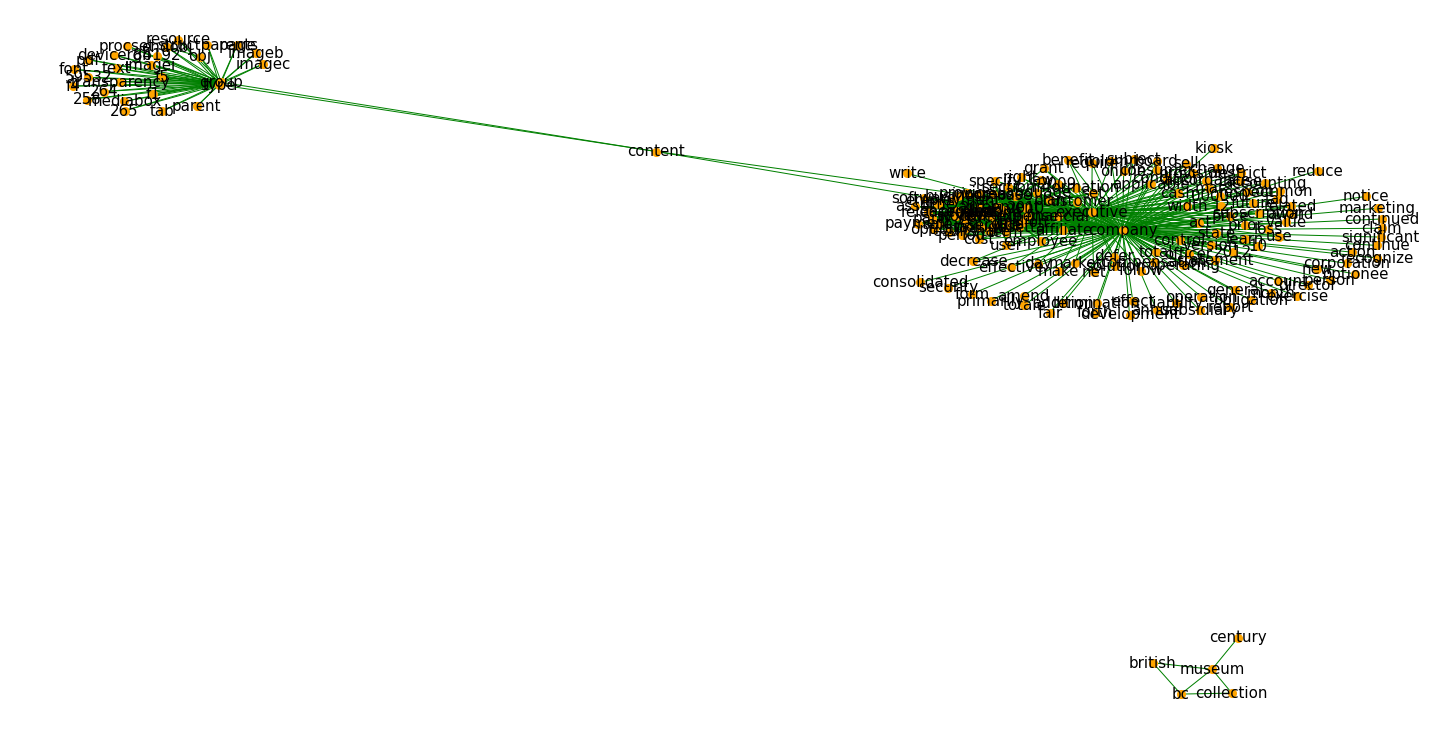

In [38]:
draw_network(df_not_nan[:per], 'lemma_text', 90000, 'ea_gc_content40000') #20000

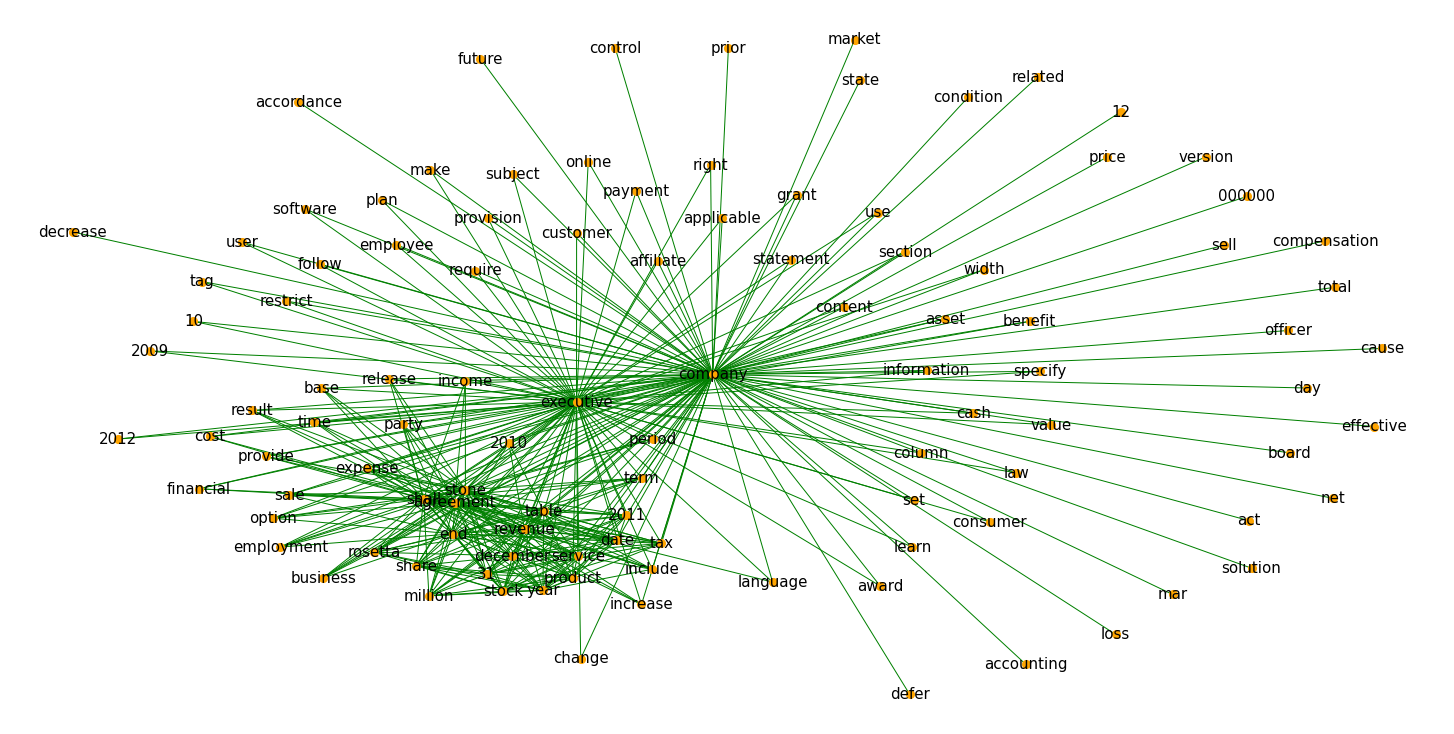

In [23]:
draw_network(df_not_nan[:per], 'lemma_text', 150000, 'ea_gc_content40000') #20000

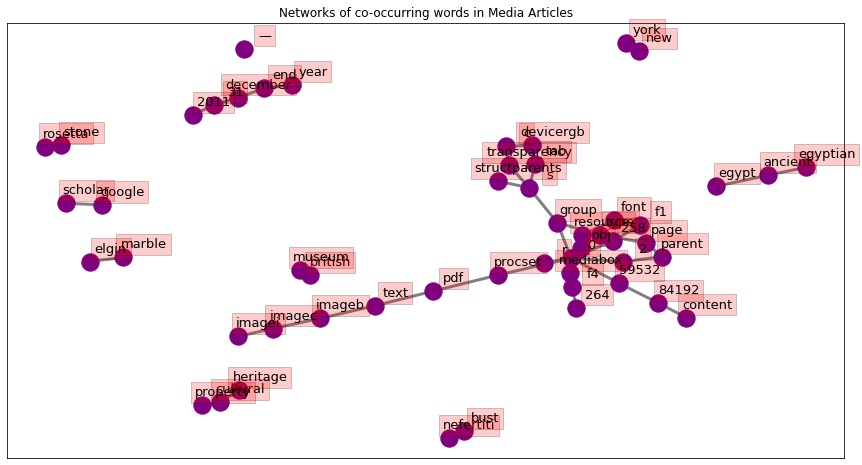

In [40]:
draw_cooccur_network(df_not_nan, 50,'lemma_text', 'Networks of co-occurring words in Media Articles')

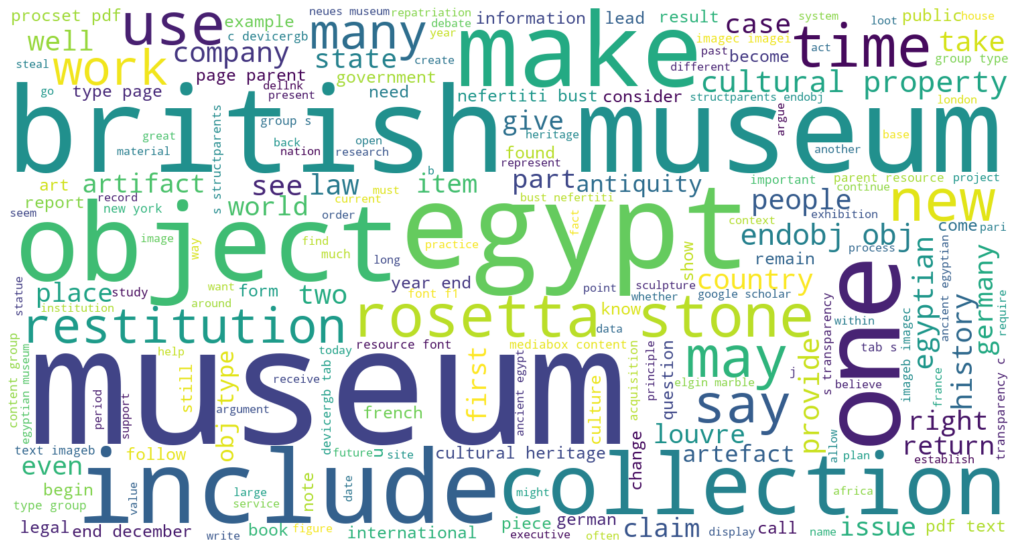

In [34]:
get_wordcloud(df_not_nan, 'lemma_text', 'ea_content_wc')

### 2. Peoples vs mentions vs ethnicity - CSV list, bar chart: Pelonomi

In [ ]:
#this section requires Spacy
#!pip install spacy
#!python -m spacy download en_core_web_sm

#### Get names first

In [15]:
import spacy

In [3]:
from nltk.corpus import stopwords

In [20]:
def NER(text):
    """Takes in a string of text and returns a dataframe of all named entities
    
        Args:
            :param text: string, a string containing entire corpus
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    entities = []
    labels = []
    position_start = []
    position_end = []

    for ent in doc.ents:
        entities.append(ent)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)

    df = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})

    return df

In [22]:
#there is a couple of nans in here (8 articles in total) including two Japanese articles hahaha
text = ''.join(x for x in df_text['text'])

In [31]:
len(text)

5257515

In [30]:
stopwords_eng = stopwords.words('english')
tokenized_doc = text.split()
no_stopwords = " ".join([item for item in tokenized_doc if item not in stopwords_eng])  

In [32]:
len(no_stopwords)

4002337

In [35]:
ner_df = NER(no_stopwords[0:1000000])
ner_df2 = NER(no_stopwords[1000000:2000000])
ner_df3 = NER(no_stopwords[2000000:3000000])

In [37]:
ner_df4 = NER(no_stopwords[3000000:4000000])

In [38]:
ner_df5 = NER(no_stopwords[4000000:])

In [46]:
ner = pd.concat([ner_df, ner_df2, ner_df3, ner_df4, ner_df5])
ner['count'] = 1
ner = ner[(ner['Labels'] == 'PERSON')]

In [47]:
ner['Entities'] = ner['Entities'].astype(str)
ner = ner.groupby('Entities').agg('sum').reset_index().sort_values('count',ascending=False)

In [64]:
exl_list = ['Benin', 'British', 'Museums', 'Rosetta Stone', 'Dendera', 'Nefertiti', 
            'Benin Bronzes', 'Denderah','Egypte']
ner = ner[~ner['Entities'].isin(exl_list)]
ner.head(40)

,Entities,count,surname,race
6778,Zahi Hawass,144,hawass,"GreaterEuropean,British"
4215,Merryman,90,merryman,"GreaterEuropean,Jewish"
314,Amarna,72,amarna,"GreaterEuropean,WestEuropean,Italian"
4537,Napoléon,59,napoleon,"GreaterEuropean,Jewish"
1952,Emmanuel Laroze,59,laroze,"GreaterEuropean,WestEuropean,French"
5108,Ptolemaic,54,ptolemaic,"GreaterEuropean,British"
2753,Hitler,51,hitler,"GreaterEuropean,British"
3239,John Henry Merryman,51,henry merryman,"GreaterEuropean,Jewish"
3897,Ludwig Borchardt,50,borchardt,"GreaterEuropean,British"
3971,Macron,50,macron,"GreaterEuropean,British"


In [65]:
ner[['Entities', 'count']].to_csv('data/egypt_media_people_mentions.csv')

I wrote to file here, started the ethnic env then read in the file and continued

In [66]:
ner = pd.read_csv('data/egypt_media_people_mentions.csv', index_col=0)

In [67]:
ner['surname'] = ner['Entities'].apply(lambda x: clean_name(x, True))

In [68]:
preds2 = pred_wiki_ln(ner, "surname")

In [69]:
preds2

,Entities,count,surname,race,"Asian,GreaterEastAsian,EastAsian","Asian,GreaterEastAsian,Japanese","Asian,IndianSubContinent","GreaterAfrican,Africans","GreaterAfrican,Muslim","GreaterEuropean,British","GreaterEuropean,EastEuropean","GreaterEuropean,Jewish","GreaterEuropean,WestEuropean,French","GreaterEuropean,WestEuropean,Germanic","GreaterEuropean,WestEuropean,Hispanic","GreaterEuropean,WestEuropean,Italian","GreaterEuropean,WestEuropean,Nordic"
6778,Zahi Hawass,144,hawass,"GreaterEuropean,British",0.009683,0.016770,0.058464,0.138795,0.274333,0.303168,0.002065,0.117173,0.008325,0.007856,0.017884,0.024223,0.021261
4215,Merryman,90,merryman,"GreaterEuropean,Jewish",0.000991,0.001219,0.001666,0.000913,0.003926,0.407554,0.031400,0.444144,0.039990,0.005667,0.052561,0.009259,0.000711
314,Amarna,72,amarna,"GreaterEuropean,WestEuropean,Italian",0.002709,0.000965,0.131780,0.010352,0.006745,0.067594,0.015774,0.047967,0.187837,0.001477,0.152924,0.372545,0.001332
4537,Napoléon,59,napoleon,"GreaterEuropean,Jewish",0.030186,0.001038,0.068825,0.175517,0.058362,0.153523,0.077512,0.188223,0.131088,0.002888,0.085839,0.023146,0.003853
1952,Emmanuel Laroze,59,laroze,"GreaterEuropean,WestEuropean,French",0.002406,0.002858,0.001013,0.057274,0.040784,0.019240,0.073091,0.071033,0.629827,0.006235,0.068055,0.027455,0.000728
5108,Ptolemaic,54,ptolemaic,"GreaterEuropean,British",0.000745,0.002628,0.001245,0.000454,0.009786,0.571365,0.004716,0.011096,0.332753,0.007543,0.009079,0.041752,0.006838
2753,Hitler,51,hitler,"GreaterEuropean,British",0.005424,0.004936,0.007808,0.005808,0.003511,0.704122,0.010399,0.171270,0.029120,0.011857,0.035648,0.006023,0.004074
3239,John Henry Merryman,51,henry merryman,"GreaterEuropean,Jewish",0.002158,0.001778,0.001563,0.001851,0.001507,0.351569,0.025096,0.528896,0.022355,0.019968,0.028007,0.013523,0.001728
3897,Ludwig Borchardt,50,borchardt,"GreaterEuropean,British",0.026331,0.011491,0.002054,0.002754,0.004538,0.292190,0.022571,0.062436,0.194628,0.125329,0.156419,0.029405,0.069855
3971,Macron,50,macron,"GreaterEuropean,British",0.023244,0.010613,0.002311,0.037240,0.004761,0.665650,0.005879,0.020877,0.173251,0.003579,0.009419,0.041029,0.002147


In [70]:
ner.groupby('surname').agg('sum').reset_index().sort_values('count', ascending=False)

,surname,count
2397,hawass,199
3754,museum,160
3854,nefertiti,103
3814,napoleon,96
3585,merryman,94
787,borchardt,92
3387,macron,90
337,amarna,80
1500,dendera,68
1392,de l'egypte,65


In [71]:
preds2['african'] = preds2['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

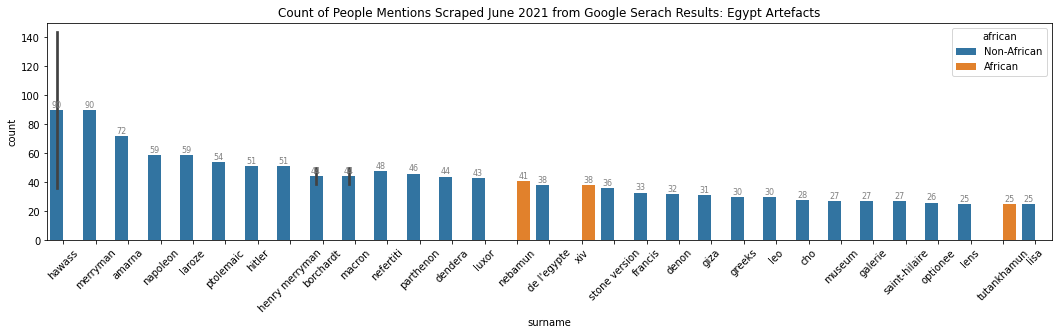

In [79]:
#manual fixes
for name in fix_list:
    preds2.loc[preds2['surname']==name, 'african'] = 'African'
    
plt.figure(figsize=[18,4])
plt.xticks(rotation=45)
plt.title('Count of People Mentions Scraped June 2021 from Google Serach Results: Egypt Artefacts')
g = sns.barplot(data=preds2[0:35], 
             x="surname", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,150) #To make space for the annotations
#plt.savefig('ea_gc_mentionsperperson.eps', format='eps')

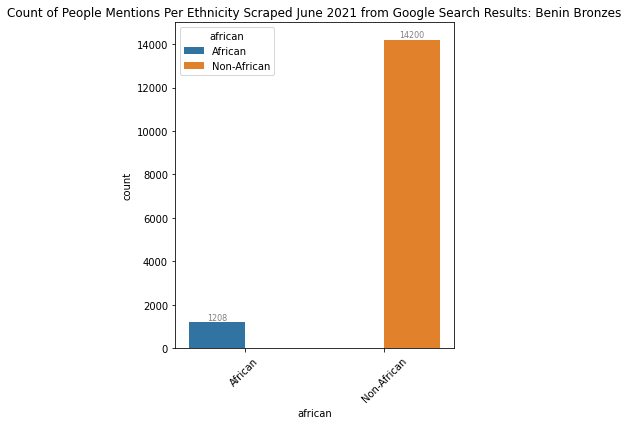

In [88]:
ratio = preds2.groupby('african').agg('sum').reset_index()
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of People Mentions Per Ethnicity Scraped June 2021 from Google Search Results: Benin Bronzes')
g = sns.barplot(data=ratio, 
             x="african", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,15000) #To make space for the annotations
#plt.savefig('ea_gc_mentionsperethnicity.eps', format='eps')

TODO: need to fix this because there are some times where only the surname is mentioned, need to group by on that before getting the ethnicity to get a proper representation of the numbers